---
---

# Introduction to DeepInsight - Decoding position, speed and head direction from tetrode CA1 recordings

This notebook stands as an example of how to use DeepInsight v0.5 on tetrode data and can be used as a guide on how to adapt it to your own datasets. All methods are stored in the deepinsight library and can be called directly or in their respective submodules. A typical workflow might look like the following: 
- Load your dataset into a format which can be directly indexed (numpy array or pointer to a file on disk)
- Preprocess the raw data (wavelet transformation)
- Preprocess your outputs (the variable you want to decode)
- Define appropriate loss functions for your output and train the model 
- Predict performance across all cross validated models
- Visualize influence of different input frequencies on model output


In [1]:
# Import DeepInsight
import sys
sys.path.insert(0, "/home/marx/Documents/Github/DeepInsight")
import deepinsight
# Choose GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
# Additional imports
from scipy.io import loadmat
import numpy as np
#import matplotlib
#matplotlib.use('nbagg')
import matplotlib.pyplot as plt

---
---
Here you can define the paths to your raw data files, and create file names for the preprocessed HDF5 datasets.

The data we use here is usually relatively large in its raw format. Running it through the next lines takes roughly 24 hours for a 40 minute recording.

We provide a preprocess file to play with the code. See next cell

In [2]:
# Define base paths
base_path = './example_data/calcium/'
fp_raw_file = base_path + 'traces_M1336.mat' # This is an example dataset containing calcium traces and linear position in a virtual track
fp_deepinsight = base_path + 'processed_M1336.h5' # This will be the processed HDF5 file
sampling_rate = 30 # Might also be stored in above mat file for easier access

In [17]:
if os.path.exists(fp_raw_file):
    # Load data 
    calcium_data = loadmat(fp_raw_file)['dataSave']
    raw_data = np.squeeze(calcium_data['df_f'][0][0])
    raw_timestamps = np.arange(0, raw_data.shape[0]) / sampling_rate
    output = np.squeeze(calcium_data['pos_dat'][0][0])
    # As the mouse is running on a virtual linear track we have a circular variable. We can solve this by either:
    # (1) Using a circular loss function or 
    # (2) Using the sin and cos of the variable
    # For this dataset I choose method (2), see the loss calculation for head directionality for an example of (1)
    output = (output - np.nanmin(output)) / (np.nanmax(output) - np.nanmin(output))
    output = (output * 2*np.pi) - np.pi # Scaled to -pi / pi
    output = np.squeeze(np.column_stack([np.sin(output), np.cos(output)]))
    output = pd.DataFrame(output).ffill().bfill().values # Get rid of NaNs
    output_timestamps = raw_timestamps # In this recording timestamps are the same for output and raw_data
        
    # Transform raw data to frequency domain
    # deepinsight.preprocess.preprocess_input(fp_deepinsight, raw_data, sampling_rate=sampling_rate, average_window=1, wave_highpass=1/500, wave_lowpass=sampling_rate, channels=np.arange(0,100))
    # # Prepare outputs
    deepinsight.preprocess.preprocess_output(fp_deepinsight, raw_timestamps, output, output_timestamps, average_window=1, dataset_name='sin_cos')

Successfully written Dataset="sin_cos" to ./example_data/calcium/processed_M1336.h5


---
---
Now we can train the model. 

The following command uses 5 cross validations to train the models and stores weights in HDF5 files

In [18]:
# Define loss functions and train model
loss_functions = {'sin_cos' : 'mse'}
loss_weights = {'sin_cos' : 1}
deepinsight.train.run_from_path(fp_deepinsight, loss_functions, loss_weights)

 [==============================] - 50s 201ms/step - loss: 0.0059 - val_loss: 0.3591
Epoch 12/20
250/250 [==============================] - 50s 200ms/step - loss: 0.0061 - val_loss: 0.3558
Epoch 13/20
250/250 [==============================] - 12s 48ms/step - loss: 0.3602

Epoch 00013: ReduceLROnPlateau reducing learning rate to 1.1199999789823778e-06.
250/250 [==============================] - 50s 200ms/step - loss: 0.0057 - val_loss: 0.3602
Epoch 14/20
250/250 [==============================] - 50s 200ms/step - loss: 0.0058 - val_loss: 0.3568
Epoch 15/20
250/250 [==============================] - 50s 200ms/step - loss: 0.0059 - val_loss: 0.3487
Epoch 16/20
250/250 [==============================] - 12s 48ms/step - loss: 0.3497

Epoch 00016: ReduceLROnPlateau reducing learning rate to 2.2399999579647556e-07.
250/250 [==============================] - 50s 200ms/step - loss: 0.0057 - val_loss: 0.3497
Epoch 17/20
250/250 [==============================] - 50s 200ms/step - loss: 0.0056 - 

In [19]:
# Get loss and shuffled loss for influence plot, both is also stored back to HDF5 file
losses, output_predictions, indices = deepinsight.analyse.get_model_loss(fp_deepinsight,
                                                                         stepsize=10)
shuffled_losses = deepinsight.analyse.get_shuffled_model_loss(fp_deepinsight, axis=1,
                                                              stepsize=10)


26/26 [==============================] - 1998s 77s/run


---
---
Above line calculates the loss and shuffled loss across the full experiment and writes it back to the HDF5 file.

Below command visualizes the influence across different frequency bands for all samples

Note that Figure 3 in the manuscript shows influence across animals, while this plot shows the influence for one animal across the experiment

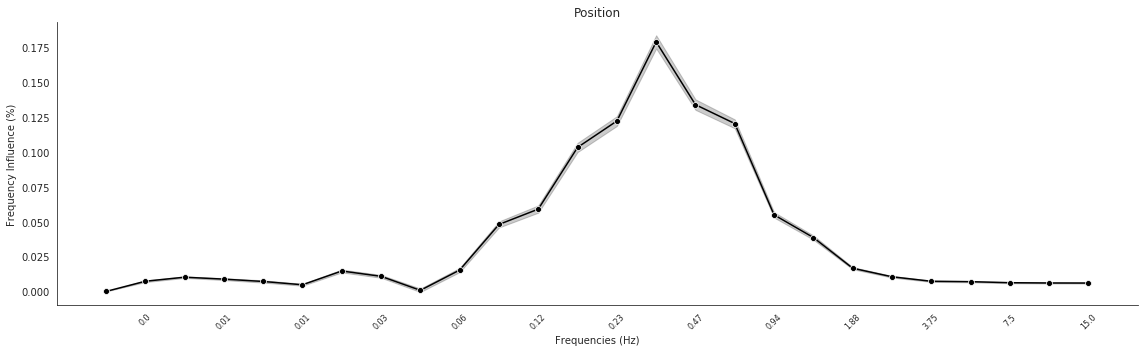

In [20]:
# Plot influence across behaviours
deepinsight.visualize.plot_residuals(fp_deepinsight, frequency_spacing=2,
                                     output_names=['Position'])

---
---